In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [182]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [57]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
           nodes.add(v) 
           for child in v._prev:
               edges.add((child, v))
               build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the grah, create a rectangular ('record) node for it
        dot.node(name = uid, label = "{ %s | data %.4f  | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is the result of an operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [185]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373580195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2  = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
o.label='o'
o.backward()

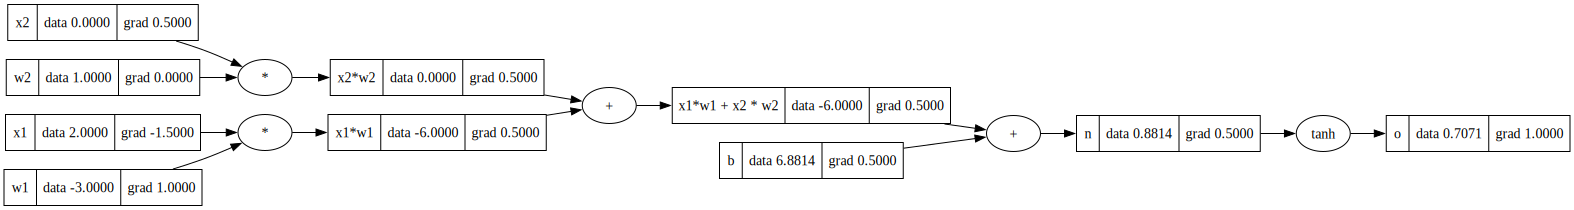

In [186]:
draw_dot(o)

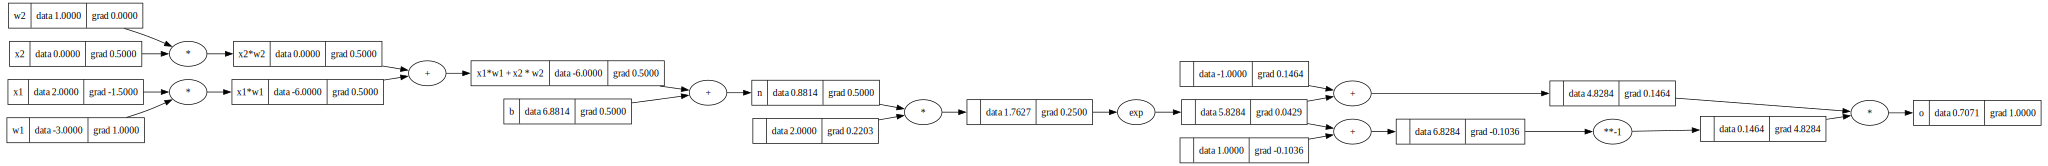

In [190]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373580195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2  = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2 * w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label='o'
o.backward()
draw_dot(o)

In [191]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range (nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
        

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range (len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [18]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.20066710801051452)

In [19]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [20]:
for k in range(100):
    # fwd pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in n.parameters():
        p.grad = 0.0 # flush grad
    loss.backward() # bkwd pass
    
    # learn
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 6.417380966459866
1 2.4940079586941684
2 2.1489402284908445
3 1.5696135271057392
4 0.17183163538138607
5 0.05829349512454204
6 0.04193994056581751
7 0.033848880213631416
8 0.02885594951721782
9 0.02539485774402182
10 0.022814340036405263
11 0.020792281535392157
12 0.0191501101478475
13 0.017780335215956403
14 0.01661405109069746
15 0.015604823764097275
16 0.01472006187696677
17 0.013936103301275649
18 0.013235272755317001
19 0.012604043505675892
20 0.012031846463854003
21 0.011510274031550078
22 0.011032532957373513
23 0.010593059030218887
24 0.010187239775348435
25 0.009811210954440201
26 0.009461704586976719
27 0.009135933638895772
28 0.008831503269001296
29 0.008546341621380207
30 0.008278645215633042
31 0.00802683538693409
32 0.0077895231942967155
33 0.007565480892908531
34 0.0073536185483285095
35 0.007152964717826324
36 0.006962650377870923
37 0.006781895464233417
38 0.006609997531198437
39 0.006446322142060109
40 0.006290294683614179
41 0.006141393359286448
42 0.00599914316356

In [21]:
ypred

[Value(data=0.9773758158581838),
 Value(data=-0.9812606408699361),
 Value(data=-0.9722019728045957),
 Value(data=0.9700916092161004)]